# **NST with Adaptive Instance Normalization** | Testing

Project for *Neural Networks and Deep Learning*, University of Padua, A.Y. 2022/23

**Students** | Francesco Pio Barone, Daniele Ninni, Paolo Zinesi

In [1]:
import time
from PIL import Image
from pathlib import Path

import torch
import torch.nn as nn
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.utils import save_image

import huang_utils

In [2]:
# reproducibility
torch.manual_seed(0)

In [3]:
# check if the GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Selected device: {device}')

Selected device: cuda


### 1 - Test images

#### 1.1 - Load content image and style image

In [4]:
content_path = Path('./image/padova-prato.jpg')
style_path   = Path('./image/starry-night.jpg')
#content_path = Path('./image/huang_content/chicago.jpg')
#style_path   = Path('./image/huang_style/asheville.jpg')

content_image = Image.open(content_path)
style_image   = Image.open(style_path)

Content image:


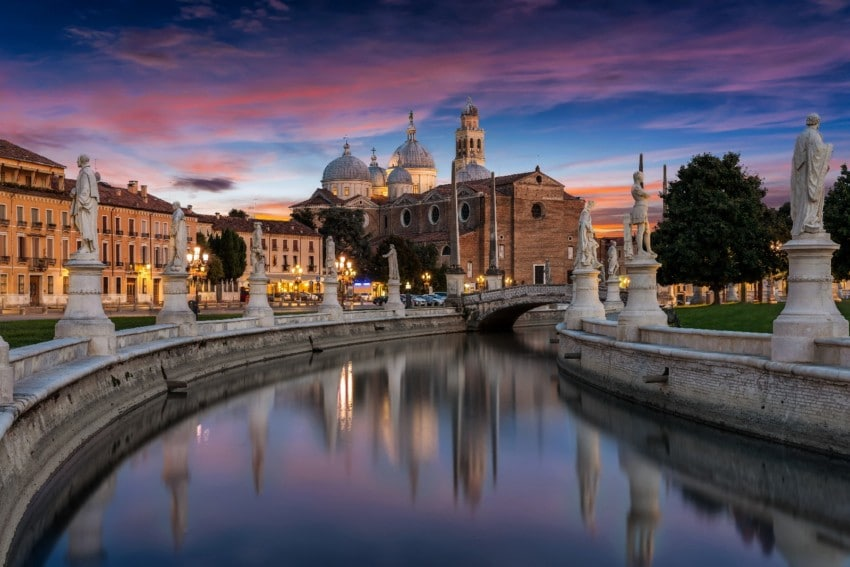

In [5]:
print('Content image:')
content_image.show()

Style image:


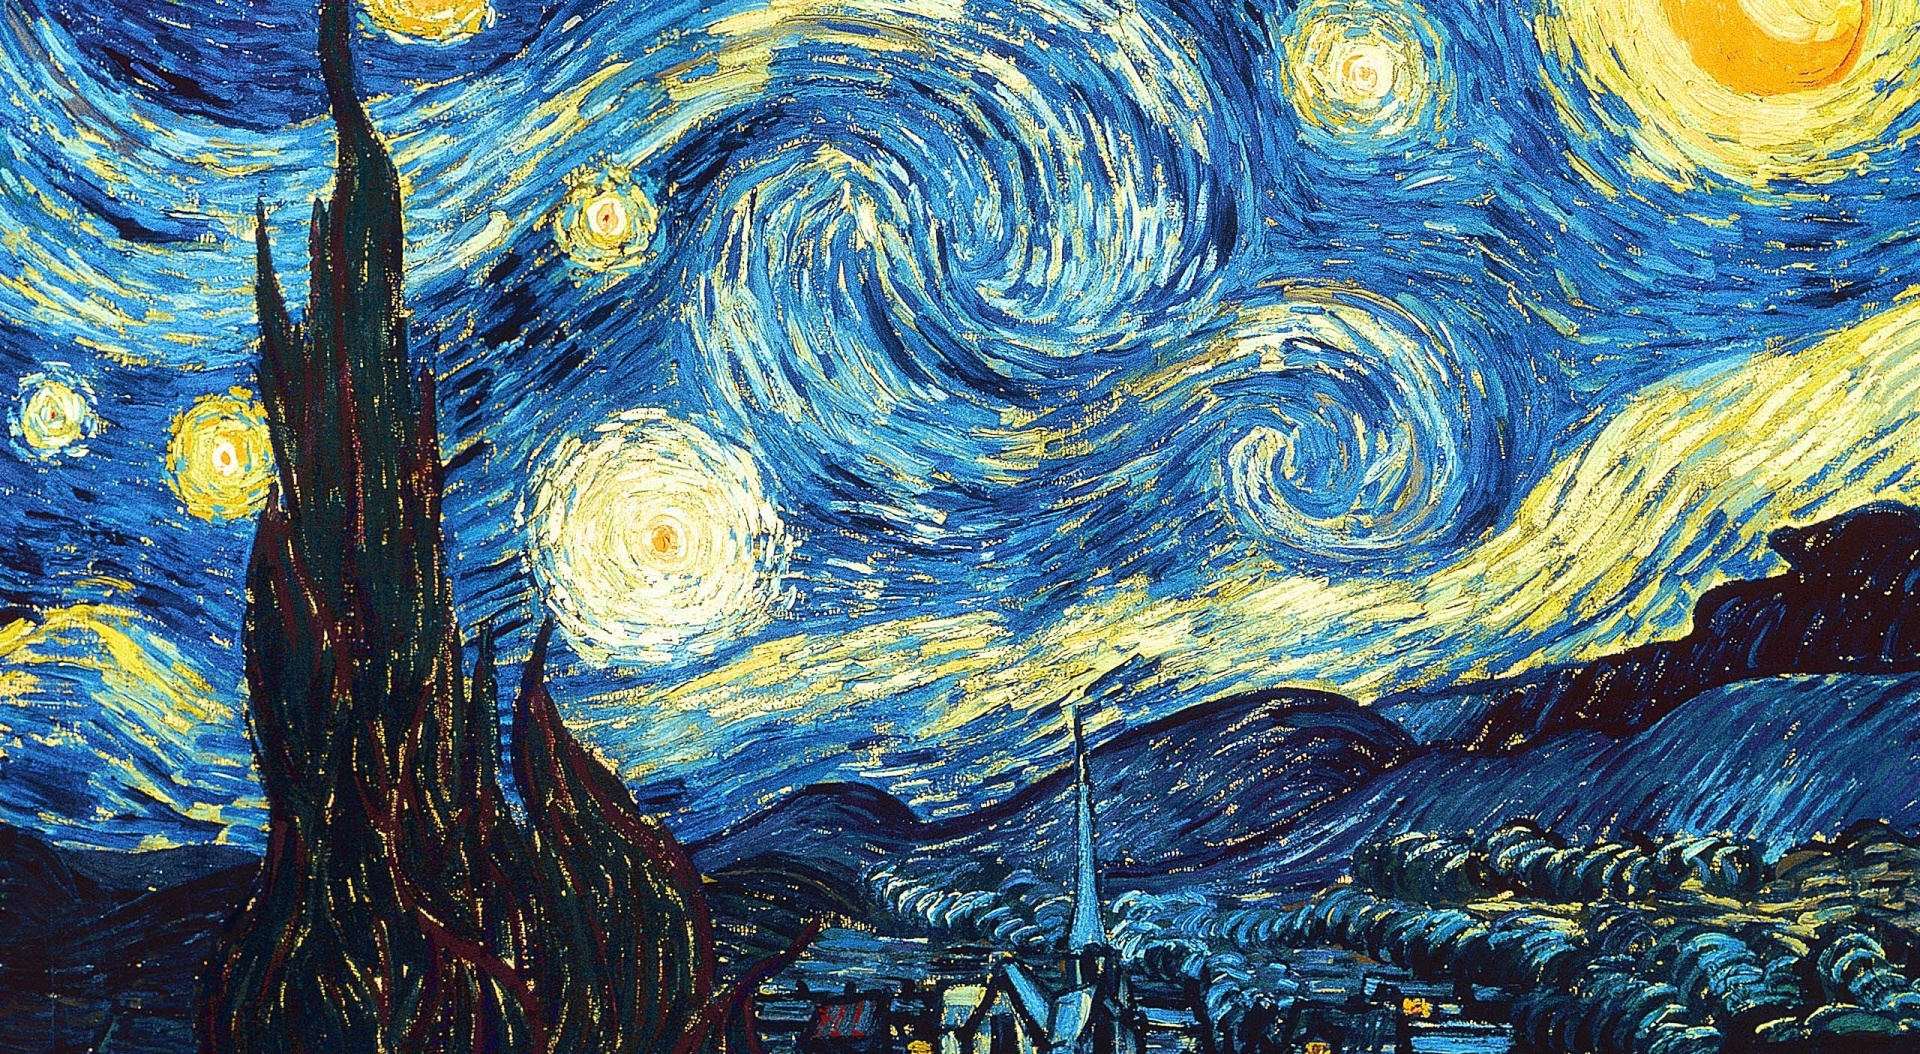

In [6]:
print('Style image:')
style_image.show()

#### 1.2 - Define the test transform

In [7]:
content_w, content_h = content_image.size

test_transform = Compose([
    Resize((content_h, content_w)),
    ToTensor()
])

### 2 - Architecture

#### 2.1 - Define the `HuangNet_test` class

In [8]:
class HuangNet_test(nn.Module):

    def __init__(self, encoder, decoder):
        
        super().__init__()
        
        # encoder
        self.encoder = encoder
        
        # decoder
        self.decoder = decoder
        
        # AdaIN layer
        self.adain = huang_utils.AdaIN()

    # forward pass
    def forward(self, content, style, alpha=1.0):
        
        assert (0.0 <= alpha <= 1.0)
        
        # content feature maps
        content_feat = self.encoder(content)
        
        # style feature maps
        style_feat = self.encoder(style)
        
        # target feature maps
        t = self.adain(content_feat, style_feat)       
        
        # content-style trade-off
        t = (1 - alpha) * content_feat + alpha * t
        
        # output image
        T = self.decoder(t)
        
        return T

### 3 - Testing

#### 3.1 - Initialize the network

In [9]:
encoder = huang_utils.build_encoder('vgg_normalised.pth')
decoder = huang_utils.build_decoder('decoder_b32.pth')

network = HuangNet_test(encoder, decoder)

#### 3.2 - Testing settings

In [10]:
# output image path
output_dir = Path('./outputs/')
output_dir.mkdir(exist_ok=True, parents=True)
output_ext = '.png'
output_path = f'{output_dir}/{content_path.stem}_STYLIZED_{style_path.stem}{output_ext}'

# content-style trade-off
alpha = 1.0

# move the network to the selected device
network.to(device);

#### 3.3 - Run NST-AdaIN

In [13]:
# set evaluation mode for the network
network.eval()

# apply test transform and move tensors to the proper device
content = test_transform(content_image).to(device).unsqueeze(0)
style   = test_transform(style_image).to(device).unsqueeze(0)

# testing
with torch.no_grad(): # no need to track the gradients
    print('NST-AdaIN Testing ... ', end='')
    tic = time.time_ns()
    output = network(content, style, alpha)
    toc = time.time_ns()
    print(f'DONE! Elapsed time: {(toc-tic)/(10**6):.2f} ms')

# save output image to file
save_image(output.cpu(), output_path)

NST-AdaIN Testing ... DONE! Elapsed time: 4.03 ms


Output image:


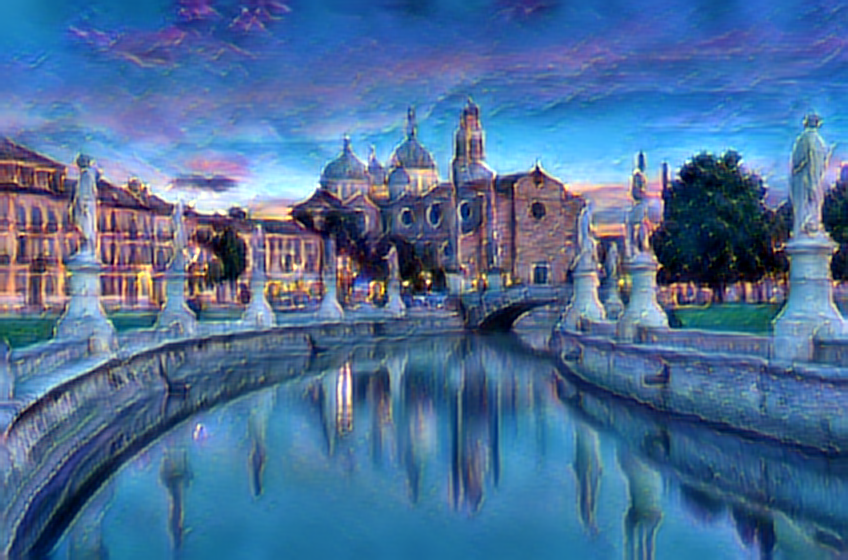

In [14]:
print('Output image:')
Image.open(output_path).show()

## **References**
- [Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization](https://openaccess.thecvf.com/content_ICCV_2017/papers/Huang_Arbitrary_Style_Transfer_ICCV_2017_paper.pdf) | Paper
- [Neural Transfer Using PyTorch](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html) | PyTorch
- [Neural Style Transfer with AdaIN](https://keras.io/examples/generative/adain) | Keras
- [AdaIN-style](https://github.com/xunhuang1995/AdaIN-style) | GitHub

***
Code by *Daniele Ninni*, last review: 10 February 2023, at 14:50